# Homework 3

## FINM 37500: Fixed Income Derivatives

### Mark Hendricks

#### Winter 2025

#### Notation Commands

$$\newcommand{\cpn}{\text{c}}$$
$$\newcommand{\Tunder}{T_\text{bond}}$$
$$\newcommand{\accint}{\xi}$$
$$\newcommand{\convert}{\psi}$$
$$\newcommand{\ctd}{\text{ctd}}$$

$$\newcommand{\refrate}{r^{\text{ref}}}$$
$$\newcommand{\pfwd}{P_{\text{fwd}}}$$
$$\newcommand{\grossbasis}{B}$$
$$\newcommand{\netbasis}{\tilde{\grossbasis}}$$
$$\newcommand{\pnl}{\Pi}$$

$$\newcommand{\years}{\tau}$$
$$\newcommand{\yearsACT}{\years_{\text{act/360}}}$$

$$\newcommand{\fwdprice}{\mathcal{F}_{t\to T}}$$
$$\newcommand{\futprice}{F_{t\to T}}$$

$$\newcommand{\fwdpriceT}{\mathcal{F}_{T\to T}}$$
$$\newcommand{\futpriceT}{F_{T\to T}}$$

$$\newcommand{\fwdpriceDT}{\mathcal{F}_{t+h\to T}}$$
$$\newcommand{\futpriceDT}{F_{t+h\to T}}$$

$$\newcommand{\rrepo}{r^{\text{repo}}}$$
$$\newcommand{\carry}{\widetilde{\cpn}}$$

***

# 1. Trading Bonds

### Data

The file `data/fut_bond_data_TYZ4_2024-08-01.xlsx` has market data on the following:
* 10-year Treasury future, expiring December 2024
* The specifications of the deliverable treasury bonds

Suppose the present date is `2024-08-01`.

In [1]:
import pandas as pd
import numpy as np
from scipy.stats import norm
from scipy.optimize import fsolve
import matplotlib.pyplot as plt
from scipy.optimize import brentq
from datetime import datetime, timedelta

path1 = "../data/fut_bond_data_TYZ4_2024-08-01.xlsx"
bond1 = pd.read_excel(path1, sheet_name='bonds').set_index('ticker')

fut1 = pd.read_excel(path1, sheet_name='future').set_index('field')



In [2]:
fut1

,TYZ4 Comdty
field,
last_update_dt,2024-08-02 00:00:00
px_last,114.234375
last_tradeable_dt,2024-12-19 00:00:00
fut_dlv_dt_last,2024-12-31 00:00:00
fut_days_expire,139
fut_ctd,T 4.25 06/30/31
fut_ctd_px,103.296875
fut_ctd_gross_basis,-9.67291
fut_ctd_net_basis,2.684063


In [3]:
bond1

,last_update_dt,px_last,maturity,days_to_mty,dur_adj_mid,cpn,nxt_cpn_dt,days_to_next_coupon,int_acc,accrued_days_between_cpn_dates,days_acc,basis_mid,repo_implied_reporate,repo_reporate,conversion
ticker,,,,,,,,,,,,,,,
91282CCS Govt,2024-08-02,84.843750,2031-08-15,2566,6.550426,1.250,2024-08-15,10,0.590659,182,172,46.253746,3.646209,5.375,0.7474
91282CDJ Govt,2024-08-02,85.062500,2031-11-15,2658,6.763513,1.375,2024-11-15,102,0.306386,184,82,55.779000,3.623413,5.375,0.7463
91282CDY Govt,2024-08-02,87.796875,2032-02-15,2750,6.816994,1.875,2024-08-15,10,0.885989,182,172,65.717750,3.675354,5.375,0.7670
91282CEP Govt,2024-08-02,94.078125,2032-05-15,2840,6.820612,2.875,2024-11-15,102,0.640625,184,82,75.048750,3.644107,5.375,0.8184
91282CFF Govt,2024-08-02,93.000000,2032-08-15,2932,6.990905,2.750,2024-08-15,10,1.299451,182,172,86.003250,3.692673,5.375,0.8060
91282CFV Govt,2024-08-02,102.531250,2032-11-15,3024,6.921134,4.125,2024-11-15,102,0.919158,184,82,NaN,3.649617,5.375,0.8851
91282CKW Govt,2024-08-02,103.296875,2031-06-30,2520,5.937053,4.250,2024-12-31,148,0.415761,184,36,43.819996,3.590292,5.375,0.9069
91282CLD Govt,2024-08-02,102.546875,2031-07-31,2551,6.038217,4.125,2025-01-31,179,0.056046,184,5,44.961746,3.594133,5.375,0.9003


### 1.1
For each bond, calculate the 
* gross basis
* carry
* net basis 

Your calculations will be more accurate if you consider that it takes time for any trade to "settle". Assume it takes one day.

#### Tip: Calculate Gross Basis using Conversion Factor

$$\underbrace{\grossbasis_{t,t+\tau}^i}_{\text{gross basis}}=\;  P_t^i - \convert^i\futprice$$

where $\convert$ denotes the **conversion factor** which is defined for each bond. You can find the conversion factor in the `conversion` column of the `bonds` sheet of the data.

Why the use of a conversion factor?
* The deliverable bonds differ in maturity and coupon, and thus range in value.
* To account for this, CBOT uses a **conversion factor** such that the futures price at delivery for bond $i$ is
$$\futpriceT\convert^i$$


#### Tip: Calculate Net Basis as Gross Basis Minus Carry

$$\begin{align*}
\text{net basis} \equiv \netbasis^i_{t,T} =& \grossbasis^i_{t,T} - \left(\cpn N - \rrepo P_t^{i,\text{dirty}}\right)\yearsACT\\
=& \grossbasis^i_{t,T} - \left[\cpn N - \rrepo \left(P_t^{i} + \accint_t^i\right)\right]\yearsACT
\end{align*}$$

recalling that
* $N$ denotes the notional, (here face value of 100)
* $\accint$ denotes accrued interest
* $\rrepo$ denotes the repo rate
* $\yearsACT$ denotes the time interval quoted as ACT/360

In [7]:
date_fwd = pd.to_datetime(fut1.loc['fut_dlv_dt_last']['TYZ4 Comdty'])
date_now = datetime(2024, 8, 1, 0, 0)

t_act = (date_fwd - date_now).days




In [55]:
def calc_fut_price(row, date_fut, date_now):
    spot = row['px_last'] + row['int_acc']
    days_fut = (date_fut - date_now).days
    days_cpn = row['days_to_next_coupon']
    cpn = row['cpn']
    repo = row['repo_implied_reporate']

    if days_fut > days_cpn:
        p_cpn = cpn / 2 * np.exp(-repo * days_cpn / 360)
    else:
        p_cpn = 0

    fut = (spot * (1 + (repo / 100) * days_fut / 360) - p_cpn) / row['conversion']

    return fut

In [14]:
px = bond1['px_last']


In [32]:
bond_fut = bond1.copy()

bond_fut['gross basis'] = bond_fut['px_last'] - float(fut1.loc['px_last']) * bond_fut['conversion']

bond_fut['carry'] = (bond_fut['cpn'] * 100 - bond_fut['repo_reporate'] * (bond_fut['px_last'] + bond_fut['int_acc'])) / 100 * 138 / 360

bond_fut['net basis'] = bond_fut['gross basis'] - bond_fut['carry']

C:\Users\xuv14\AppData\Local\Temp\ipykernel_51584\660343077.py:3: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  bond_fut['gross basis'] = bond_fut['px_last'] - float(fut1.loc['px_last']) * bond_fut['conversion']


In [33]:
bond_fut[['gross basis', 'carry', 'net basis']]

,gross basis,carry,net basis
ticker,,,
91282CCS Govt,-0.535022,-1.281138,0.746116
91282CDJ Govt,-0.190614,-1.231871,1.041257
91282CDY Govt,0.179109,-1.108487,1.287596
91282CEP Govt,0.588712,-0.849518,1.438230
91282CFF Govt,0.927094,-0.888795,1.815889
91282CFV Govt,1.422405,-0.550259,1.972664
91282CKW Govt,-0.302280,-0.507746,0.205466
91282CLD Govt,-0.298333,-0.532798,0.234465


In [26]:
(bond_fut['px_last'] + bond_fut['int_acc'])

ticker
91282CCS Govt     85.434409
91282CDJ Govt     85.368886
91282CDY Govt     88.682864
91282CEP Govt     94.718750
91282CFF Govt     94.299451
91282CFV Govt    103.450408
91282CKW Govt    103.712636
91282CLD Govt    102.602921
dtype: float64

### 1.2.
If you were required to put on a position today
* long one of the bonds
* short the future

which would you choose based on the data provided in the spreadsheet?

**Answer**

The smallest net basis means that the bond is probably cheapest to deliver.

Negative net basis

If the net basis is negative, arb is possible.
We would choose 91282CKW Govt.


### 1.3.

Calculate the conversion factor for each bond. Report it to `6` decimal places.

Do they match the conversion factor provided by Bloomberg?


#### Tip: Calculating the Conversion Factor

CBOT calculates the conversion for any bond as the discounted cashflows of the bond, where every cashflow is discounted by 6\%.
* Yes, this conversion factor formula always uses 6\%, regardless of actual interest rates.

In [58]:
bond1.columns

Index(['last_update_dt', 'px_last', 'maturity', 'days_to_mty', 'dur_adj_mid',
       'cpn', 'nxt_cpn_dt', 'days_to_next_coupon', 'int_acc',
       'accrued_days_between_cpn_dates', 'days_acc', 'basis_mid',
       'repo_implied_reporate', 'repo_reporate', 'conversion'],
      dtype='object')

In [59]:
(bond_fut['days_to_mty'] - bond_fut['days_to_next_coupon']) / 182

ticker
91282CCS Govt    14.043956
91282CDJ Govt    14.043956
91282CDY Govt    15.054945
91282CEP Govt    15.043956
91282CFF Govt    16.054945
91282CFV Govt    16.054945
91282CKW Govt    13.032967
91282CLD Govt    13.032967
dtype: float64

In [60]:
def calc_conv_factor(row):
    disc = 0.06
    cpn_num = 1 + round((row['days_to_mty'] - row['days_to_next_coupon']) / 182)

    days_mat = row['days_to_mty']

    # add in the notional
    tot_val = np.exp(- disc * days_mat / 360)

    for i in range(cpn_num):
        # add in cpns
        cpn_days = i * 182 + row['days_to_next_coupon']
        tot_val += np.exp(- disc * cpn_days / 360) * row['cpn'] / 200

    return tot_val


In [61]:
bond_fut['calc_conv'] = bond_fut.apply(lambda row: calc_conv_factor(row), axis=1)

In [62]:
bond_fut['calc_conv']

ticker
91282CCS Govt    0.728369
91282CDJ Govt    0.724804
91282CDY Govt    0.752786
91282CEP Govt    0.804800
91282CFF Govt    0.798551
91282CFV Govt    0.877545
91282CKW Govt    0.897144
91282CLD Govt    0.885496
Name: calc_conv, dtype: float64

### 1.4 

Calculate the forward price of each bond.

Use the forward prices to do an alternate calculation of net basis, using the formula in the discussion notebook.

Does this calculation agree with the net basis calculation which used gross basis minus carry?


#### Calculate net basis using forward price 

Net basis is also calculated with the same formula as gross basis, but replacing the spot price with the forward price:

$$\text{net basis} \equiv \netbasis^i_{t,T} = \fwdprice^i - \futprice\convert^i$$

recalling that
* $\fwdprice$ denotes the forward price
* $\futprice$ denotes the futures price
* $\convert$ denotes the bond's conversion factor

As we saw in Week 2, no-arbitrage (and frictionless markets) would imply the forward price is exactly the spot price minus carry, in which case this definition would match.

### Forward Price

The forward price is given by the no-arbitrage relationship:

$$\begin{align*}
\text{dirty} \fwdprice =& (P_t^i + \accint_t^i)\left(1+\rrepo_t\, \yearsACT\right)\\
\fwdprice =& (P_t^i + \accint^i_t)\left(1+\rrepo_t\, \yearsACT\right) - \accint_T
\end{align*}$$


#### With interim coupons
If there are interim coupons, the no-arbitrage relationship still holds,
* buy the bond at the dirty price
* simultaneously repo it
* when the coupon pays, use it to reduce the repo balance
* finally, at the terminal date, close out the repo

$$\begin{align*}
\text{dirty} \fwdprice =& \left[(P_t^i + \accint_t)\left(1+\rrepo_t\, \tau_0\right)-100\frac{\cpn}{2}\right]\left(1+\rrepo_t\, \tau_1\right)\\
\fwdprice =& \left[(P^i_t + \accint^i_t)\left(1+\rrepo_t\, \tau_0\right)-100\frac{\cpn}{2}\right]\left(1+\rrepo_t\, \tau_1\right) - \accint^i_T
\end{align*}$$
where
* $\tau_0$ denotes the pre-coupon forward interval, $t_{\text{coupon}}-t$ denoted as ACT/360
* $\tau_1$ denotes the pre-coupon forward interval, $T-t_{\text{coupon}}$ denoted as ACT/360
* note that $\tau=\tau_0+\tau_1$, so the formula is simply splitting the forward interval into pre and post-coupon intervals.

In [63]:
def calc_fwd_price(row, date_fwd, date_now):
    """
    Calculate forward price of a bond given spot price, repo rate, and accrued interest.
    
    Parameters:
    - row: Pandas Series containing bond data
    - date_fwd: Futures settlement date (datetime object)
    - date_now: Current date (datetime object)
    
    Returns:
    - Forward price of the bond
    """
    
    # Extract relevant data
    spot = row['px_last'] + row['int_acc']
    cpn = row['cpn']
    cpn_dt = pd.to_datetime(row['nxt_cpn_dt'])  # Ensure it's a datetime
    repo = row['repo_implied_reporate'] / 100

    # Compute days forward
    days_fwd = (date_fwd - date_now).days

    # Determine days accrued correctly
    if cpn_dt > date_fwd:  # If the next coupon is after the futures date
        days_acc = (date_fwd - date_now).days  # Use days from today to futures
    else:  # If the next coupon is before futures date
        days_acc = (date_fwd - cpn_dt).days  # Use days from last coupon to futures
    
    # Ensure days_acc is non-negative
    days_acc = max(days_acc, 0)
    days_cpn = row['accrued_days_between_cpn_dates']
    acc_int = (cpn / 2) * (days_acc / days_cpn)

    fwd = spot * (1 + repo * days_fwd / 360) - acc_int
    return fwd


In [64]:
import numpy as np

def calc_fwd_price(row, date_fwd, date_now):
    """
    Calculate the forward price of a bond correctly incorporating the no-arbitrage relationship with interim coupons.
    
    Parameters:
    - row: Pandas Series containing bond data
    - date_fwd: Futures settlement date (datetime object)
    - date_now: Current date (datetime object)
    
    Returns:
    - Corrected forward price of the bond
    """
    
    # Extract bond data
    spot = row['px_last']  # Clean price
    acc_int = row['int_acc']  # Accrued interest today (ξ_t^i)
    cpn = row['cpn']  # Annual coupon rate
    repo = row['repo_implied_reporate'] / 100  # Convert repo rate to decimal
    
    # Time periods in years
    tau_0 = (date_fwd - date_now).days / 360  # Time to futures settlement
    nxt_cpn_dt = row['nxt_cpn_dt']
    
    # Check if a coupon is received before settlement
    if nxt_cpn_dt < date_fwd:
        tau_1 = (date_fwd - nxt_cpn_dt).days / 360  # Time from coupon to futures expiry
        pv_coupon = (cpn / 2) * (1 + repo * tau_1)  # Discounted coupon
    else:
        tau_1 = 0
        pv_coupon = 0  # No coupon received before settlement

    # Compute forward price using corrected formula
    fwd_price = ((spot + acc_int) * (1 + repo * tau_0)) - pv_coupon

    return fwd_price


In [65]:
bond_fut['fwd price'] = bond_fut.apply(lambda row: calc_fwd_price(row, date_fwd, date_now), axis=1)

bond_fut['net basis fwd'] = bond_fut['fwd price'] - bond_fut['fut price'] * bond_fut['conversion']

bond_fut[['fwd price', 'fut price', 'net basis', 'net basis fwd']]

,fwd price,fut price,net basis,net basis fwd
ticker,,,,
91282CCS Govt,86.115945,115.312929,0.037020,-0.068938
91282CDJ Govt,85.984249,115.809543,-0.334286,-0.444413
91282CDY Govt,89.108351,116.313622,0.054845,-0.104197
91282CEP Govt,94.731921,116.891736,-0.701971,-0.932276
91282CFF Govt,94.375237,117.281324,0.079842,-0.153511
91282CFV Govt,102.972408,117.852425,-1.008322,-1.338773
91282CKW Govt,105.284817,115.557561,-1.308780,0.485664
91282CLD Govt,104.159944,115.694706,-1.741667,0.000000


Given my use of logs for some and approximations for others, this makes sense that there is some discrepancy.

***

# 2. Fed Funds Futures

The file `data/fedfutures_2025-01-31.xlsx` has market data on the following:
* Fed Fund Futures Chain out 18 months.
* Dates of upcoming Fed meetings (approximated in 2026.)
* Spot Fed Funds data
* Prices of the futures chain on a historic date.

Suppose the present date is `2024-01-31`.

In [42]:
fed_fut_path = "../data/fedfutures_2025-01-31.xlsx"
fed_meetings = pd.read_excel(fed_fut_path, sheet_name="fed meetings")
spot_fed_funds = pd.read_excel(fed_fut_path, sheet_name="fed funds").set_index('date')
fed250131 = pd.read_excel(fed_fut_path, sheet_name="2025-01-31").set_index('last_tradeable_dt')
fed250126 = pd.read_excel(fed_fut_path, sheet_name="2025-01-26").set_index('last_tradeable_dt')
fed240729 = pd.read_excel(fed_fut_path, sheet_name="2024-07-29").set_index('last_tradeable_dt')



date_now = datetime(2024, 1, 31, 0, 0)

display(fed250131)

display(fed250126)

,ticker,px_last,open_int
last_tradeable_dt,,,
2025-02-28,FFG5 Comdty,95.675,503574
2025-03-31,FFH5 Comdty,95.690,320421
2025-04-30,FFJ5 Comdty,95.715,318741
2025-05-30,FFK5 Comdty,95.770,360361
2025-06-30,FFM5 Comdty,95.830,156189
2025-07-31,FFN5 Comdty,95.900,194301
2025-08-29,FFQ5 Comdty,95.950,70271
2025-09-30,FFU5 Comdty,95.985,46060
2025-10-31,FFV5 Comdty,96.030,52800


,ticker,px_last
last_tradeable_dt,,
2025-02-28,FFG5 Comdty,95.675
2025-03-31,FFH5 Comdty,95.705
2025-04-30,FFJ5 Comdty,95.755
2025-05-30,FFK5 Comdty,95.810
2025-06-30,FFM5 Comdty,95.875
2025-07-31,FFN5 Comdty,95.955
2025-08-29,FFQ5 Comdty,96.005
2025-09-30,FFU5 Comdty,96.040
2025-10-31,FFV5 Comdty,96.085


### 2.1. Chart the Fed Futures Rates

Chart the Fed Funds curve at
* `2025-01-26`
* `2025-01-31`

Note that you are charting the implied Fed Funds Futures *rate*, not price.

Comment on how today's **open interest** varies across the chain.

<Axes: xlabel='last_tradeable_dt'>

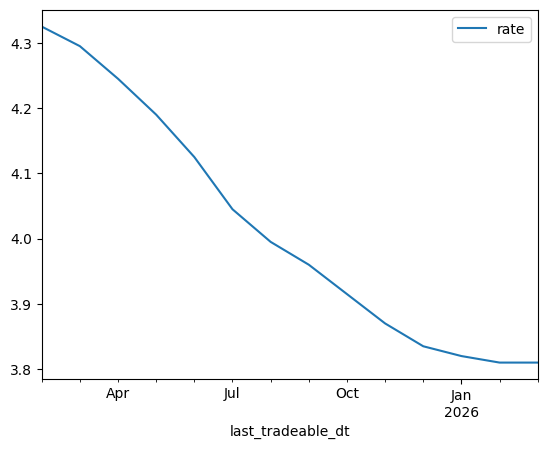

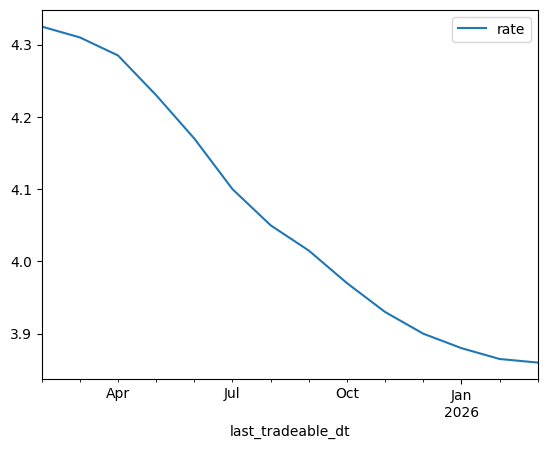

In [43]:
fed250131['rate'] = 100 - fed250131['px_last']
fed250126['rate'] = 100 - fed250126['px_last']

fed250126[['rate']].plot()
fed250131[['rate']].plot()



**Answer**

As you go further into the future, the open interest on the chain reduces drastically. There is the most open interest at the soonest future.

### 2.2 Extracting the Expected Path of Fed Funds Rates

Assume the Fed...
* sets the rate exactly at its list of meeting dates.
* does not change the rate betweeen meeting dates.

Use the present data to calculate--and plot--the implied set of expected Fed Funds rates as of each meeting date.

#### Technical Point
* Consider months, $t$, where there is a meeting, but such that in month $t+1$ there is no meeting.
* There will be two reasonable ways to extract the expected fed funds rate:
    1. Use the futures rate from the $t+1$-contract
    2. Calculate the implied rate for the remainder of month $t$, knowing the expected rate at the end of month $t+1$.
* These are both reasonable and will likely not differ much.

Try to make reasonable assumptions as needed. to implement the calculation.

In [44]:
fed250131['prev date'] = fed250131.index.to_series().shift()

In [45]:
display(fed_meetings)

display(fed250131)

,meeting dates
0,2025-03-19
1,2025-05-07
2,2025-06-18
3,2025-07-30
4,2025-09-17
5,2025-10-29
6,2025-12-10
7,2026-01-29
8,2026-03-18


,ticker,px_last,open_int,rate,prev date
last_tradeable_dt,,,,,
2025-02-28,FFG5 Comdty,95.675,503574,4.325,NaT
2025-03-31,FFH5 Comdty,95.690,320421,4.310,2025-02-28
2025-04-30,FFJ5 Comdty,95.715,318741,4.285,2025-03-31
2025-05-30,FFK5 Comdty,95.770,360361,4.230,2025-04-30
2025-06-30,FFM5 Comdty,95.830,156189,4.170,2025-05-30
2025-07-31,FFN5 Comdty,95.900,194301,4.100,2025-06-30
2025-08-29,FFQ5 Comdty,95.950,70271,4.050,2025-07-31
2025-09-30,FFU5 Comdty,95.985,46060,4.015,2025-08-29
2025-10-31,FFV5 Comdty,96.030,52800,3.970,2025-09-30


In [46]:
# use the futures chain from 2025-01-31

fed_meetings['next_dt'] = fed_meetings['meeting dates'].shift(-1) - timedelta(days=1)

fed_meetings

,meeting dates,next_dt
0,2025-03-19,2025-05-06
1,2025-05-07,2025-06-17
2,2025-06-18,2025-07-29
3,2025-07-30,2025-09-16
4,2025-09-17,2025-10-28
5,2025-10-29,2025-12-09
6,2025-12-10,2026-01-28
7,2026-01-29,2026-03-17
8,2026-03-18,NaT


In [47]:
def calc_implied_rate_init(row, df_rate):
    first_dt = row['meeting dates']
    second_dt = row['next_dt']

    # want a meeting date to envelop 2 consecutive month ends
    for dt, rate_row in df_rate.iterrows():
        try:
            if first_dt < rate_row['prev date'] and second_dt > dt:
                return rate_row['rate']
            else:
                continue
        except:
            continue

    return 0



    


In [48]:
fm25 = fed_meetings.copy()
fm25['implied rate'] = fed_meetings.apply(lambda row: calc_implied_rate_init(row, df_rate=fed250131), axis=1)

fm25

,meeting dates,next_dt,implied rate
0,2025-03-19,2025-05-06,4.285
1,2025-05-07,2025-06-17,0.000
2,2025-06-18,2025-07-29,0.000
3,2025-07-30,2025-09-16,4.050
4,2025-09-17,2025-10-28,0.000
5,2025-10-29,2025-12-09,3.930
6,2025-12-10,2026-01-28,0.000
7,2026-01-29,2026-03-17,3.865
8,2026-03-18,NaT,0.000


In [49]:
def calc_fill_missing_rate(df_meet, df_rate):
    prev_rate = 0

    imp_rate_list = []
    for i, row in df_meet.iterrows():
        if row['implied rate'] != 0:
            prev_rate = row['implied rate']
            imp_rate_list.append(prev_rate)
            continue
    
        first_dt = row['meeting dates']
        
        for dt, rate_row in df_rate.iterrows():
        
            if first_dt < dt:
                f_day = first_dt.day - 1
                tot_day = dt.day

                imp_rate = (tot_day * rate_row['rate'] - f_day * prev_rate) / (tot_day - f_day)

                row['implied rate'] = imp_rate
                prev_rate = imp_rate
                imp_rate_list.append(imp_rate)
                break            
            else:
                continue

    df_meet['implied rate'] = imp_rate_list
    return df_meet





In [50]:
fm25 = calc_fill_missing_rate(fm25, fed250131)

fm25

,meeting dates,next_dt,implied rate
0,2025-03-19,2025-05-06,4.285000
1,2025-05-07,2025-06-17,4.216250
2,2025-06-18,2025-07-29,4.109519
3,2025-07-30,2025-09-16,4.050000
4,2025-09-17,2025-10-28,3.975000
5,2025-10-29,2025-12-09,3.930000
6,2025-12-10,2026-01-28,3.887727
7,2026-01-29,2026-03-17,3.865000
8,2026-03-18,NaT,3.853929


<Axes: xlabel='meeting dates'>

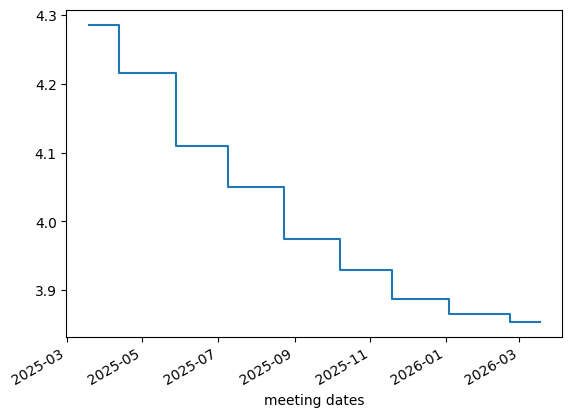

In [54]:

fm25['implied rate'].plot(drawstyle='steps-mid')

### 2.3 Compare to the Historic Curve

Use the price data in `2024` to extract the expectations at the previous date.
* Note that you do not need to "bootstrap" up from the historic date to the current date. 

Compare this to the answer in the previous problem, for the current data.

In [67]:
fed240729['rate'] = 100 - fed240729['px_last']
fed240729['prev date'] = fed240729.index.to_series().shift()

fed240729

,ticker,px_last,rate,prev date
last_tradeable_dt,,,,
2024-08-30,FFQ4 Comdty,94.6825,5.3175,NaT
2024-09-30,FFU4 Comdty,94.7900,5.2100,2024-08-30
2024-10-31,FFV4 Comdty,94.9500,5.0500,2024-09-30
2024-11-29,FFX4 Comdty,95.0750,4.9250,2024-10-31
2024-12-31,FFZ4 Comdty,95.2050,4.7950,2024-11-29
2025-01-31,FFF5 Comdty,95.3500,4.6500,2024-12-31
2025-02-28,FFG5 Comdty,95.5150,4.4850,2025-01-31
2025-03-31,FFH5 Comdty,95.6000,4.4000,2025-02-28
2025-04-30,FFJ5 Comdty,95.7300,4.2700,2025-03-31


In [68]:
fm24 = fed_meetings.copy().iloc[:5]

fm24

# can only price this many due to missing dates

,meeting dates,next_dt
0,2025-03-19,2025-05-06
1,2025-05-07,2025-06-17
2,2025-06-18,2025-07-29
3,2025-07-30,2025-09-16
4,2025-09-17,2025-10-28


In [69]:
fm24['implied rate'] = fed_meetings.apply(lambda row: calc_implied_rate_init(row, df_rate=fed240729), axis=1)

In [70]:
fm24 = calc_fill_missing_rate(fm24, fed240729)
display(fm24)
display(fm25)

,meeting dates,next_dt,implied rate
0,2025-03-19,2025-05-06,4.270000
1,2025-05-07,2025-06-17,4.101250
2,2025-06-18,2025-07-29,3.936827
3,2025-07-30,2025-09-16,3.855000
4,2025-09-17,2025-10-28,3.747857


,next_dt,implied rate
meeting dates,,
2025-03-19,2025-05-06,4.285000
2025-05-07,2025-06-17,4.216250
2025-06-18,2025-07-29,4.109519
2025-07-30,2025-09-16,4.050000
2025-09-17,2025-10-28,3.975000
2025-10-29,2025-12-09,3.930000
2025-12-10,2026-01-28,3.887727
2026-01-29,2026-03-17,3.865000
2026-03-18,NaT,3.853929


**Answer**

We see above that the 2025 expectations for Fed funds are a bit less than the 2024 expectations at the same time points.

***